In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input/fasam-nlp-competition-turma-5"))
print(os.listdir("../input/"))

['test.csv', 'train.csv', 'sample_submission.csv']
['fasam-nlp-competition-turma-5', 'fasttextportuguese300txt']


### Problema

A magazine needs to catalog all its news in different categories. The goal of this competition is to develop the best deep learning model to predict the categoty of new news.

Possible categories are:

- ambiente (environment)
- equilibrioesaude (balance and health)
- sobretudo (about everything)
- educacao (education)
- ciencia (science)
- tec (tec)
- turismo (tourism)
- empreendedorsocial (social entrepreneurs)
- comida (food)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

sns.set(style="ticks")
warnings.filterwarnings("ignore")

In [3]:
import keras
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from keras.regularizers import *
from keras.models import Sequential
from keras.callbacks import *
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [4]:
import io

# Data preprocessing

In [5]:
# Leitura do Dataset
df = pd.read_csv('../input/fasam-nlp-competition-turma-5/train.csv')
print(df.shape)
df.head()

(7894, 4)


,article_id,title,text,category
0,8409,Muralha de Lisboa é rota arqueológica com mais...,O urbanismo anárquico dos bairros mais antigos...,turismo
1,5714,Endeavor lança mapa inédito sobre negócios soc...,As empresas sociais mostraram que é possível u...,empreendedorsocial
2,9263,Falta de neve no Chile atrasa abertura de esta...,Ao menos quatro estações de esqui no centro do...,turismo
3,2649,Gravidez causa mudanças no cérebro das mulheres,"A gravidez provoca mudanças físicas ""duradoura...",ciencia
4,6698,Facebook provoca erros em aplicativo para test...,"Alguma vez você já ouviu a frase ""o Facebook e...",tec


In [6]:
# sequence size
titles_seq_size = 20
texts_seq_size  = 200

# max tokens
max_tokens    = 5000

# embedding size
embed_dim    = 300

In [7]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [8]:
%%time
embedding_vectors = load_vectors('../input/fasttextportuguese300txt/wiki.pt.vec')

CPU times: user 1min 4s, sys: 4.43 s, total: 1min 8s
Wall time: 1min 8s


In [9]:
def build_embedding_matrix(embedding, word_index):    
    not_found = []
    embedding_matrix = np.zeros((max_tokens + 1, embed_dim))
    for word, i in word_index.items():
        if i > max_tokens:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # words not found in embedding index will be all-zeros
            not_found.append(word)
    return embedding_matrix, not_found        

In [10]:
tokenizer    = Tokenizer(num_words=max_tokens + 1, split=' ')
tokenizer.fit_on_texts(np.concatenate([df['text'].values, df['title'].values]))

def preprocess(data, embedding, seq_size):
    
    dt = tokenizer.texts_to_sequences(data)   

    # unify length
    X = pad_sequences(dt, maxlen=seq_size)
    
    embedding_matrix, not_found = build_embedding_matrix(embedding_vectors, tokenizer.word_index)
    print("{} words were not found".format(len(not_found)))
    return X, embedding_matrix

In [11]:
%%time
X_title, em_title = preprocess(df['title'], embedding_vectors, titles_seq_size)
X_text, em_text = preprocess(df['text'], embedding_vectors, texts_seq_size)

182 words were not found
182 words were not found
CPU times: user 6.56 s, sys: 68 ms, total: 6.63 s
Wall time: 6.61 s


In [12]:
X_text.shape, X_title.shape

((7894, 200), (7894, 20))

In [13]:
# format categories
y_classes = pd.get_dummies(df['category']).columns
y = pd.get_dummies(df['category']).values

In [14]:
y_classes

Index(['ambiente', 'ciencia', 'comida', 'educacao', 'empreendedorsocial',
       'equilibrioesaude', 'sobretudo', 'tec', 'turismo'],
      dtype='object')

In [15]:
y

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [16]:
y.shape

(7894, 9)

# Create Base Model

In [17]:
def create_model():
    # Prepare inputs
    x_1 = Input(shape=(titles_seq_size,))
    t_1 = Embedding(max_tokens + 1, embed_dim, weights=[em_title], trainable=False)(x_1)
    x_2 = Input(shape=(texts_seq_size,))
    t_2 = Embedding(max_tokens + 1, embed_dim, weights=[em_text], trainable=False)(x_2)
    
    # Concatenate inputs
    t = Concatenate(axis=1)([t_1, t_2])
    
    # Conv Layers
    t = Conv1D(16, kernel_size=2, strides=2, activation='relu')(t)
    t = Dropout(0.5)(t)
    t = Conv1D(16, kernel_size=3, strides=2, activation='relu')(t)
    t = Dropout(0.5)(t)
    t = Conv1D(32, kernel_size=3, strides=2, activation='relu')(t)
    t = Flatten()(t)
    # Dense Layer
    pred = Dense(len(y_classes), activation='softmax')(t)
    
    model = Model(inputs=[x_1, x_2], outputs=[pred])
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer='adam',
                  metrics = ['accuracy'])
    
    model.summary()
    
    return model

model = create_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 300)      1500300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 300)     1500300     input_2[0][0]                    
____________________________________________________________________________________________

In [18]:
X_title_train, X_title_val, X_text_train, X_text_val, y_train, y_val = train_test_split(X_title, X_text, y,
                                                  test_size = 0.33, random_state = 31, stratify=y)

model_file = "model.h5"


hist = model.fit([X_title_train, X_text_train], y_train, 
                 validation_data =([X_title_val, X_text_val], y_val),
                 batch_size=16, nb_epoch = 30, 
#                  verbose = 1,
                 callbacks=[
                     ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max',
                                     verbose=1, save_best_only=True),
                 EarlyStopping(monitor='val_accuracy', mode='max', patience=10,
#                                verbose=1
                              )])
model.load_weights(model_file)

Train on 5288 samples, validate on 2606 samples
Epoch 1/30
5288/5288 [==============================] - 7s 1ms/step - loss: 1.8836 - accuracy: 0.2831 - val_loss: 1.4831 - val_accuracy: 0.4747

Epoch 00001: val_accuracy improved from -inf to 0.47467, saving model to model.h5
Epoch 2/30
5288/5288 [==============================] - 3s 516us/step - loss: 1.4104 - accuracy: 0.4809 - val_loss: 1.2761 - val_accuracy: 0.5476

Epoch 00002: val_accuracy improved from 0.47467 to 0.54758, saving model to model.h5
Epoch 3/30
5288/5288 [==============================] - 3s 504us/step - loss: 1.1983 - accuracy: 0.5675 - val_loss: 1.0754 - val_accuracy: 0.6086

Epoch 00003: val_accuracy improved from 0.54758 to 0.60860, saving model to model.h5
Epoch 4/30
5288/5288 [==============================] - 3s 485us/step - loss: 1.0289 - accuracy: 0.6197 - val_loss: 0.9806 - val_accuracy: 0.6489

Epoch 00004: val_accuracy improved from 0.60860 to 0.64889, saving model to model.h5
Epoch 5/30
5288/5288 [=======

# Plot the training curves

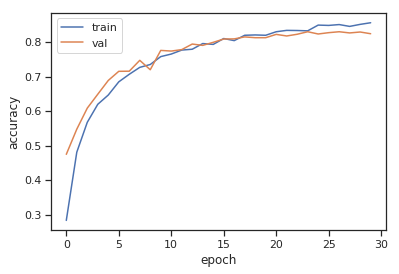

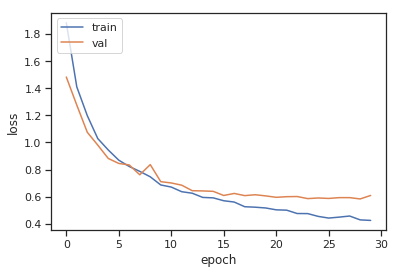

In [19]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# Prepare submission

In [20]:
# model evaluation

val_loss, val_acc = model.evaluate([X_title_val, X_text_val], y_val)

print('Accuracy: ' + str(val_acc * 100) + '%')

2606/2606 [==============================] - 0s 108us/step
Accuracy: 83.00076723098755%


In [21]:
test_df = pd.read_csv('../input/fasam-nlp-competition-turma-5/test.csv')
print(test_df.shape)
test_df.head()

(4251, 3)


,article_id,title,text
0,4763,Enem 2016 aumenta 46% o uso do nome social por...,O número de travestis e transexuais que usará ...
1,52,'Viagem ao Japão é aula de cultura e tradição'...,"O ator Jayme Matarazzo, 31, aproveita os inter..."
2,7682,Fotógrafo registra a beleza natural de países ...,"O fotógrafo Vitor Schietti, 29, passou quase u..."
3,10292,Azar genético explica preferência do Aedes aeg...,"Enquanto alguns sofrem, outros escapam incólum..."
4,7435,Parto humanizado e capital humano ganham apoio...,A Womanity Foundation anunciou no início do mê...


In [22]:
def predict(df):
    X_title, _ = preprocess(df['title'], embedding_vectors, titles_seq_size)
    X_text, _ = preprocess(df['text'], embedding_vectors, texts_seq_size)
    pred     = model.predict([X_title, X_text], batch_size=16)
    print(np.max(pred, axis=-1))
    return np.argmax(pred, axis=-1)

In [23]:
test_df.shape

(4251, 3)

In [24]:
pred         = predict(test_df)
pred_classes = [y_classes[c] for c in pred]
pred_classes[:5]

182 words were not found
182 words were not found
[0.99938655 0.93387926 0.99931836 ... 0.6516475  0.76730657 0.9998566 ]


['educacao', 'turismo', 'turismo', 'ciencia', 'empreendedorsocial']

In [25]:
test_df['category'] = pred_classes
test_df.head()

,article_id,title,text,category
0,4763,Enem 2016 aumenta 46% o uso do nome social por...,O número de travestis e transexuais que usará ...,educacao
1,52,'Viagem ao Japão é aula de cultura e tradição'...,"O ator Jayme Matarazzo, 31, aproveita os inter...",turismo
2,7682,Fotógrafo registra a beleza natural de países ...,"O fotógrafo Vitor Schietti, 29, passou quase u...",turismo
3,10292,Azar genético explica preferência do Aedes aeg...,"Enquanto alguns sofrem, outros escapam incólum...",ciencia
4,7435,Parto humanizado e capital humano ganham apoio...,A Womanity Foundation anunciou no início do mê...,empreendedorsocial


In [26]:
test_df[["article_id", "category"]].to_csv("submission.csv", index=False)